# Create covariate stacks

### Covariates will be derived by reducing satellite imagery to useful modelling layers
#### Covariates can include: Landsat 8, NASADEM, Sentinel-2, Sentinel-1

### Inputs:
#### bbox_img_tile: An image tile extent will provide the bbox that accesses cloud-optimized GeoTiffs
#### filters: search for imagery based on days-of-year, cloudcover, year range
##### Note: Image tile extent will be dictated by data volume of covars & CPU RAM

In [1]:
# Search for imagery
# https://github.com/developmentseed/example-jupyter-notebooks/blob/landsat-search/notebooks/Landsat8-Search/L8-USGS-satapi.ipynb
import os
import json
import requests
import datetime

sat_api_url = "https://landsatlook.usgs.gov/sat-api"

def query_satapi(query):
    headers = {
            "Content-Type": "application/json",
            "Accept-Encoding": "gzip",
            "Accept": "application/geo+json",
        }

    url = f"{sat_api_url}/stac/search"
    data = requests.post(url, headers=headers, json=query).json()
    
    return data

def query_year(year, bbox, min_cloud, max_cloud):
    '''Given the year, finds the number of scenes matching the query and returns it.'''
    date_min = '-'.join([str(year), "06-01"])
    date_max = '-'.join([str(year), "09-15"])
    start_date = datetime.datetime.strptime(date_min, "%Y-%m-%d")
    end_date = datetime.datetime.strptime(date_max, "%Y-%m-%d") 
    start = start_date.strftime("%Y-%m-%dT00:00:00Z")
    end = end_date.strftime("%Y-%m-%dT23:59:59Z")
    
    query = {
    "time": f"{start}/{end}",
    "bbox":bbox,
    "query": {
        "eo:platform": {"eq": "LANDSAT_8"},
        "eo:cloud_cover": {"gte": min_cloud, "lt": max_cloud},
        "collection":{"eq": "landsat-c2l2-sr"},
        "landsat:collection_category":{"eq": "T1"}
        },
    "limit": 20 # We limit to 500 items per Page (requests) to make sure sat-api doesn't fail to return big features collection
    }
    
    data = query_satapi(query)
    
    # you can't trouble shoot if you don't return the actual results
    return data

In [4]:
# Accessing imagery
# Select an area of interest
#bbox_list = [[-105,45,-100,50], [-101,45,-100,46]] # Not Boreal Enough
bbox_list = [[-116,50,-112,55],[-116.5,50.5,-115.5,51.5]]
min_cloud = 0
max_cloud = 20
years = range(2015,2020 + 1)
for bbox in bbox_list:
    # Geojson of total scenes - Change to list of scenes
    response_by_year = [query_year(year, bbox, min_cloud, max_cloud ) for year in years]
    scene_totals = [each['meta']['found'] for each in response_by_year]
    print(scene_totals)

[40, 50, 67, 56, 29, 56]
[7, 13, 19, 17, 4, 15]


In [16]:
### Optional ###
# Take the search over several years, write the geojson response for each
save_path = '/projects/alexdevseed/landsat8/sample2'
if (not os.path.isdir(save_path)): os.mkdir(save_path)
for yr in range(1,len(years)):
    catalog = os.path.join(save_path, f'response-{years[yr]}.json')
    with open(catalog, 'w') as jsonfile:
        json.dump(response_by_year[yr], jsonfile)

## Debugging

The next few code chunks were inserted just to debug why the query was returning so many results for such a small bounding box. The answer was that bbox needs to be outside the query, and adding a platform and tier to the query reduces even more. Note: everything in the query section follows a very specific format. TODO link the STAC docs explaining the query language.

In [30]:
# It's better to just return the whole response, so you can iterate and debug through it.
#bbox_list = [[-105,45,-100,50], [-101,45,-100,46]]
#min_cloud = 0
#max_cloud = 20

#yr = 2020
#response = query_year(yr, bbox_list[1], min_cloud, max_cloud) 
#scenes = response['meta']['found']
#scenes

In [45]:
# Some helpful ways to debug
#response['features'][0]
#for item in response['features']: print(item['id'])

LC08_L2SP_031029_20200915_20200919_02_T1
LC08_L2SP_032029_20200906_20200918_02_T1
LC08_L2SP_031029_20200830_20200906_02_T1
LC08_L2SP_033028_20200828_20200906_02_T1
LC08_L2SP_031029_20200814_20200920_02_T1
LC08_L2SP_033028_20200812_20200918_02_T1
LC08_L2SP_032029_20200805_20200916_02_T1
LC08_L2SP_032029_20200805_20200821_02_T1
LC08_L2SP_033028_20200727_20200908_02_T1
LC08_L2SP_033028_20200727_20200806_02_T1
LC08_L2SP_032029_20200704_20200913_02_T1
LC08_L2SP_031029_20200627_20200823_02_T1
LC08_L2SP_031028_20200627_20200824_02_T1
LC08_L2SP_031028_20200611_20200824_02_T1
LC08_L2SP_031029_20200611_20200824_02_T1


### Exploring Results as Spatial layer

The return from the api is a valid geojson per page. You can directly plot this on a map (e.g. folium). Below is an expirement to convert to geopandas, however only the 'properties' key is maintained as an attribute, which isn't going to work since we also need the 'assests'. TODO: Need to flatten the json before loading to geopandas.

In [7]:
%pip install -q folium
%pip install -q geopandas
%pip install -q shapely

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import geopandas as gpd
import folium
import shapely as shp

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [69]:
# Silly but it's easier to write the json to file and read back in right now to get a valid geopandas frame.
# Dilemna reading geojson with geopandas only pull the "properties" in as attributes
#with open(f'response-{yr}.json', 'w') as jsonfile:
#    json.dump(response, jsonfile)

#scenes_poly1 = gpd.read_file('response.json')
#scenes_poly1.head()

In [9]:
# This works but you have to manually set the crs
yr = 0
scenes_poly = gpd.GeoDataFrame.from_features(response_by_year[yr], crs='epsg:4326')
for col in scenes_poly.columns: print(col)

scenes_poly.head()


geometry
collection
eo:gsd
eo:platform
eo:off_nadir
datetime
eo:cloud_cover
eo:sun_azimuth
eo:sun_elevation
eo:instrument
landsat:cloud_cover_land
landsat:wrs_type
landsat:wrs_path
landsat:wrs_row
landsat:scene_id
landsat:collection_category
landsat:collection_number
eo:bands


,geometry,collection,eo:gsd,eo:platform,eo:off_nadir,datetime,eo:cloud_cover,eo:sun_azimuth,eo:sun_elevation,eo:instrument,landsat:cloud_cover_land,landsat:wrs_type,landsat:wrs_path,landsat:wrs_row,landsat:scene_id,landsat:collection_category,landsat:collection_number,eo:bands
0,"POLYGON ((-118.49783 51.34652, -115.92969 50.8...",landsat-c2l2-sr,30,LANDSAT_8,0,2015-08-12,1.75,150.784357,51.637969,OLI_TIRS,1.75,2,44,25,LC80440252015224LGN01,T1,02,"[{'name': 'SR_B1', 'common_name': 'coastal', '..."
1,"POLYGON ((-117.89902 52.76147, -115.24930 52.3...",landsat-c2l2-sr,30,LANDSAT_8,0,2015-08-12,2.25,152.379351,50.551883,OLI_TIRS,2.25,2,44,24,LC80440242015224LGN01,T1,02,"[{'name': 'SR_B1', 'common_name': 'coastal', '..."
2,"POLYGON ((-114.81137 52.76215, -112.15990 52.3...",landsat-c2l2-sr,30,LANDSAT_8,0,2015-06-27,2.00,148.264403,58.635764,OLI_TIRS,2.00,2,42,24,LC80420242015178LGN01,T1,02,"[{'name': 'SR_B1', 'common_name': 'coastal', '..."
3,"POLYGON ((-115.40926 51.34637, -112.83816 50.8...",landsat-c2l2-sr,30,LANDSAT_8,0,2015-06-27,1.04,146.117358,59.645130,OLI_TIRS,1.04,2,42,25,LC80420252015178LGN01,T1,02,"[{'name': 'SR_B1', 'common_name': 'coastal', '..."
4,"POLYGON ((-118.49655 51.34680, -115.92839 50.8...",landsat-c2l2-sr,30,LANDSAT_8,0,2015-06-25,15.48,146.231020,59.744489,OLI_TIRS,15.48,2,44,25,LC80440252015176LGN03,T1,02,"[{'name': 'SR_B1', 'common_name': 'coastal', '..."


In [10]:
#sc_bbox = scenes_poly.total_bounds #scene boundaries is not as useful as the original bbox to query
# TODO: loop over years to check that the bbox is covered, n < 8 in 1 year testing has less than full coverage.
sc_bbox = bbox_list[1]
sc_bbox_polygon = shp.geometry.box(sc_bbox[0], sc_bbox[1], sc_bbox[2], sc_bbox[3])
center = sc_bbox_polygon.centroid

m = folium.Map(
    location=[center.y,center.x],
    tiles="cartodbpositron",
    zoom_start=6,
)

bbox_style = {'fillColor': '#ff0000', 'color': '#ff0000'}

folium.GeoJson(scenes_poly, name="geojson").add_to(m)
folium.GeoJson(sc_bbox_polygon,
               name="bbox",
               style_function=lambda x:bbox_style).add_to(m)

m

## Accessing Data

Now that we've queried for which landsat scenes to use in a given analysis tile, we need to setup AWS authentication and iterate over the assets, subsetting based on the tile (bbox). An AWS IAM account access key and secret are required so the bill goes to the right place for any requester pays costs.

In [5]:
# Skip if you already have everything installed
%pip install -q python-dotenv
%pip install -q boto3
%pip install -q rasterio
%pip install -q pyproj
# TODO add the CURL ssl path to the .env file
%env CURL_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
env: CURL_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt


In [41]:
# load env variables from a .env file
import os
import rasterio as rio
from rasterio.session import AWSSession 
import numpy as np
import pyproj
import boto3
from matplotlib.pyplot import imshow
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
# One option is to read this from the env, should work in ADE
# TODO: how do you pass secrets to DPS jobs?

aws_access_key_id=os.getenv('aws_access_key_id')
aws_secret_access_key=os.getenv('aws_secret_access_key')
if aws_access_key_id is None:
    aws_access_key_id = input("AWS Access Key Id")
if aws_secret_access_key is None:
    aws_secret_access_key = input("AWS Secret Access Key")


In [42]:
# Processing imagery (band math)
# is this done on the fly? No


# Authenticate to aws to access a requester pays bucket
aws_session = AWSSession(boto3.Session(aws_access_key_id=aws_access_key_id,
                                      aws_secret_access_key=aws_secret_access_key),
                        requester_pays=True)

In [ ]:
# Verify what credential are being used and that requester pays is set if needed
aws_session.credentials

### Verify that S3 access works

In [16]:
# The returned data is actually geojson, could load into a geopandas dataframe

# Get the first feature, and lookup the url of Band 4 asset
asset = response_by_year[0]['features'][1]['assets']['SR_B3.TIF']['href']

# Convert to S3 url for use with requester pays
cog = asset.replace('https://landsatlook.usgs.gov/data/', 's3://usgs-landsat/')
print(cog)

s3://usgs-landsat/collection02/level-2/standard/oli-tirs/2015/032/028/LC08_L2SP_032028_20150824_20200908_02_T1/LC08_L2SP_032028_20150824_20200908_02_T1_SR_B3.TIF


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7921, 'height': 8031, 'count': 1, 'crs': CRS.from_epsg(32614), 'transform': Affine(30.0, 0.0, 248385.0,
       0.0, -30.0, 5218815.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


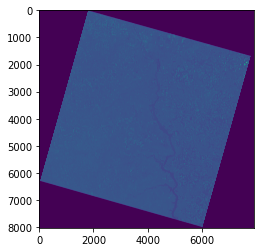

In [18]:
# Basic access example
with rio.Env(aws_session):
    with rio.open(cog) as src:
        profile = src.profile
        arr = src.read(1)
        print(profile)

#plot the raster
imshow(arr)

### Cache the results

1. Cache the json from the query (save as files)
1. Loop over a few of them, and download the source
1. Write a new copy of the json with internal ADE urls to the same files

In [58]:
import boto3
import botocore

aws_session2 = boto3.session.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
)
s3 = aws_session2.resource('s3')

In [74]:
# read the json file catalog
def write_local_catalog(catalog, bands):
    '''Given path to a response json from a sat-api query, make a copy changing urls to local paths'''
    with open(catalog) as f:
        asset_catalog = json.load(f)
        for feature in asset_catalog['features']:
            new_dir = os.path.join(save_path, feature['id'])
            if (not os.path.isdir(new_dir)): os.mkdir(new_dir)
            #download the assests
            for band in bands:
                try:
                    key = feature['assets'][f'SR_{band}.TIF']['href'].replace('https://landsatlook.usgs.gov/data/', '')
                    output_file = os.path.join(new_dir, os.path.basename(key))
                    #print(key)
                    s3.Bucket('usgs-landsat').download_file(key, output_file, ExtraArgs={'RequestPayer':'requester'})
                    feature['assets'][f'SR_{band}.TIF']['href'] = output_file
                except botocore.exceptions.ClientError as e:
                    if e.response['Error']['Code'] == "404":
                        print("The object does not exist.")
                    else:
                        raise
        # save and updated catalog with local paths
        local_catalog = catalog.replace('response', 'local')
        with open(local_catalog,'w') as jsonfile:
            json.dump(asset_catalog, jsonfile)
        
        return local_catalog

In [ ]:
bands = [''.join(["B",str(item)])for item in range(2,7,1)]
local_catalogs = [write_local_catalog(catalog, bands) for catalog in ]

### Get Stacks of Data

For each scene, request a subset fitting the tile bbox and stack all the required bands.
Alternately one could just save each file as is - but long term this is not the cloud optimized method.

In [1]:
def reproject_bbox(src, bbox, bbox_crs='epsg:4326'):
    '''
    Convert the bounding box to local coordinates of the data
    src is the raster data handler
    bbox, and bbox_crs supplied by user
    returns a rasterio window object 
    '''
    # bbox has 2 sets, row,col
    data_crs=pyproj.Proj(src.crs)
    bbox_crs=pyproj.Proj(init=bbox_crs)
    lower = pyproj.transform(bbox_crs, data_crs, bbox[0], bbox[1])
    upper = pyproj.transform(bbox_crs, data_crs, bbox[2], bbox[3])
    
    bottom, left = src.index(lower[0], lower[1])
    top, right = src.index(upper[0], upper[1])
    
    # merge back into a window
    # Remember gdal reads from the upper left corner
    width = abs(top-bottom)
    height = abs(right-left)
    local_window = rasterio.windows.Window(left, top, width, height)
    #print(local_window)
    return local_window

def extract_subset(cog, bbox, band):
    '''
    Given a path to an S3 COG geotiff, a bbox in latlon(e.g. wgs84), a band.
    Extracts a subset of an image by reading a window. 
    When used with COGs will only read the required portion of the file.
    BBOX format [minX, minY, maxX, maxY]
    bbox = [11.6, -0.1, 11.7, -0.0]
    Band is the layer in the file, a single band tif, only has 1.
    '''
    
    with rio.Env(aws_session):
        with rasterio.open(cog) as src:
            local_window = reproject_bbox(src, bbox, bbox_crs='epsg:4326')
            # query the subset with a window
            # todo: modify to allow multiband data sources
            subset = src.read(band, window=local_window)
        
    return subset, src.crs, src.transform

In [ ]:
## Retrieving Pixels
bands = [2,3,4,5,6]
bbox = bbox_list[1]
# TODO: 
# Loop over each scene
response = response_by_year[1]
# Each season should actually be it's own DPS job
for item in response['features']:
    # for each scene Loop over bands 2,3,4,5,6 (assets)
    for band in bands:
        # For each scene, read subset set by bounding box
        asset = item['assets'][f'SR_B{band}.TIF']['href']
        # Convert to S3 url for use with requester pays
        cog = asset.replace('https://landsatlook.usgs.gov/data/', 's3://usgs-landsat/')
        print(cog) 
        # Since the source files are per band, the 1st band in a given file is default
        # Bound Box reprojected on the fly to the native projection of the asset
        #subset, crs, transform = extract_subset(cog, bbox, 1)

    # stack the bands into the same array with n layers (z direction)?
    # optional: calculate indexes based on the bands and store as additional layers
    # save cog to disk (could be a kea or Zarr(xarray))
# after looping, make a VRT of cogs so it can be treated as a single file ?

# Questions, 
# 1. should the tiling scheme be LonLat 1 degree, the end Equal area projection, or utm zone based? take bbox reproject to LonLat for the query
# 2. do we need the QA band or can we do that separate, the only limitation on cogs is that the storage type needs to be identical in all bands. Kea or Zarr could accomodate, or if the pixels are cloud filtered before saving the stack then a COG is ok.

## Greenest Pixel Selection

In [33]:
# Test case for making greenest pixel comps with numpy arrays
import numpy as np
#imagine 3 ndvi layers from 3 seperate images such that

ndvi1 = np.array([[1.2, 1.2, np.NaN],[1.2, 2.2, 1.2],[1.2, 1.2, 1.2]])

ndvi2 = np.array([[2.2, 2.2, 2.2],[2.2, 1.2, 2.2],[2.2, 2.2, 2.2]])

ndvi3 = np.array([[2.2, 1.2, 3.2],[1.2, 1.2, 1.2],[2.2, 2.2, 3.2]])

print('ndvi1 = ', ndvi1)
print('ndvi2 = ', ndvi2)
print('ndvi3 = ', ndvi3)

ndvi1 =  [[1.2 1.2 nan]
 [1.2 2.2 1.2]
 [1.2 1.2 1.2]]
ndvi2 =  [[2.2 2.2 2.2]
 [2.2 1.2 2.2]
 [2.2 2.2 2.2]]
ndvi3 =  [[2.2 1.2 3.2]
 [1.2 1.2 1.2]
 [2.2 2.2 3.2]]


In [34]:
# Now 3 'Red' bands where numbers can be anything
#(but kept the same here for easy tracking, such that:)

Red1 = np.array([[5, 5, 5],[5, 5, 5],[5, 5, 5]])

Red2 = np.array([[6, 6, 6],[6, 6, 6],[6, 6, 6]])

Red3 = np.array([[7, 7, 7],[7, 7, 7],[7, 7, 7]])

print(Red1)
print(Red2)
print(Red3)
# create array of all Green bands

Stack = np.array([Red1, Red2, Red3])

[[5 5 5]
 [5 5 5]
 [5 5 5]]
[[6 6 6]
 [6 6 6]
 [6 6 6]]
[[7 7 7]
 [7 7 7]
 [7 7 7]]


In [36]:
# now, find the index value (position) of the max ndvi layers (based on
# first axis: imagine drilling down through a stack/cube)

max = np.nanargmax((ndvi1,ndvi2,ndvi3),axis=0,)
print(max)

[[1 1 2]
 [1 0 1]
 [1 1 2]]


In [26]:
# Index the Green bands in 'Stack' based on argmax index position
RedComposite = Stack[max,max,max]

In [27]:
print(RedComposite)

[[6 6 5]
 [6 5 6]
 [6 6 7]]
